### In this notebook we'll see, how using dataset library you can write simple regression models. 

You can see the implementation of the used MyBatch class in [mybatch.py](https://github.com/analysiscenter/az_training/blob/anton_broilovskiy/task_01/mybatch.py).
Data generation function in [data_generator.py](https://github.com/analysiscenter/az_training/blob/anton_broilovskiy/task_01/data_generator.py). And create models function in [models.py](https://github.com/analysiscenter/az_training/blob/anton_broilovskiy/task_01/models.py).

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from mybatch import MyBatch
from models import Regressions
from data_generator import generate_linear_data, \
                           generate_logistic_data, \
                           generate_poisson_data
from dataset import Dataset, DatasetIndex, V, F, B

## First we consider linear regression, that allows solving the task where the answer is a continuous variable.
In this example we show how work linear regression. For this we generate data from uniform or normal distribution, multiply with normal distributed weights and the addition of a normally distributed error and try to predict it.

In [2]:
size = 1000
linear_x, linear_y = generate_linear_data(size=size)

Now we create dataset with our class named __MyBatch__ and split it on train/test. We need dataset for create a batch in future, but now the dataset is empty until we load the data unto it. You can read more about now all Dataset works [here](https://github.com/analysiscenter/dataset/tree/master/doc) and about create Dataset [here](https://github.com/analysiscenter/dataset/blob/master/doc/dataset.md).

In [3]:
linear_dset = Dataset(np.arange(size), batch_class=MyBatch)
linear_dset.cv_split()

After create a dataset we need to load data and train linear regression model, that implemented into [model](https://github.com/analysiscenter/az_training/blob/anton_broilovskiy/task_01/models.py) class.
We can train it on batch of generated data, which we preload before. For this we create __pipeline__, that allow use train model in one line of code! You can read more [here](https://github.com/analysiscenter/dataset/blob/master/doc/pipeline.md).

In pipeline we create a linear regression model and train it use train_model function. You can read how it works [here](https://github.com/analysiscenter/dataset/blob/master/doc/models.md). 

In [4]:
inputs_config = {'input': {'shape': (13)},
                 'labels': {'shape': (1),
                            'name': 'targets'}}

In [5]:
BATCH_SIZE = 100
train_linear = (linear_dset.train.p
                .load((linear_x, linear_y))
                .init_variable('loss_values', init_on_each_run=list)
                .init_model('dynamic',
                            Regressions,
                            'linear',
                            config={'inputs': inputs_config,
                                    'loss': 'mse',
                                    'optimizer': {'name':'GradientDescentOptimizer',
                                                  'learning_rate': 0.01},
                                    'input_block/inputs': 'input',
                                    'body/units': 1,
                                    'output': {}})
                .train_model('linear',
                             fetches='loss',
                             feed_dict={'input': B('input_data'),
                                        'labels': B('labels')},
                            save_to=V('loss_values'), mode='a')
                .run(BATCH_SIZE, shuffle=True, n_epochs=100))

In [6]:
BATCH_SIZE = 1
test_linear = (linear_dset.test.p
                .import_model('linear', train_linear)
                .load((linear_x, linear_y))
                .init_variable('predict', init_on_each_run=list)
                .predict_model('linear', 
                             fetches='Regressions/predictions',
                             feed_dict={'input': B('input_data'),
                                        'labels': B('labels')},
                             save_to=V('predict'), mode='a')
                .run(BATCH_SIZE, shuffle=False, n_epochs=1))

In last __pipeline__ we test our model. Let's see, how good it do it.

In [7]:
predict = np.array(test_linear.get_variable('predict')).reshape(-1)
target = np.array(linear_y[linear_dset.test.indices]).reshape(-1)

percent = np.mean(np.abs((target - predict) * 100 / target))

print('Percentage of errors: {}%'.format(round(percent, 3)))

Percentage of errors: 0.895%


# Logistic regression 
It solve the task in the case where answer is binary (0 or 1, -1 or 1 and etc)
In this case we generate two clouds of points with different classes and fit logistic regression to predict points class.

In [8]:
size = 500
logistic_x, logistic_y = generate_logistic_data(size, [[1,2],[[15,0],[0,15]]], [[10,17],[[15,0],[0,15]]])

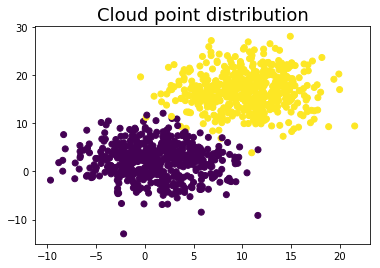

In [9]:
plt.scatter(logistic_x[:,0], logistic_x[:,1], c=logistic_y)
plt.title('Cloud point distribution', fontsize=18)

One of the most important thing that you need to know is that it really dosen't matter, which model you want to train and what data you will using for it.The interface always be the same. And now we'll see it.

First of all, we, as in the previues time, create dataset and split it. Only in the preloaded data and the size of dataset was difference. 

In [10]:
logistic_dset = Dataset(np.arange(size), batch_class=MyBatch)
logistic_dset.cv_split()

As you can see, structure of pipeline was same, change only the name of methods, that contain model and name it model.

In [11]:
inputs_config = {'input': {'shape': (2)},
                 'labels': {'shape': (1),
                            'name': 'targets'}}

In [12]:
BATCH_SIZE=10
train_logistic = (logistic_dset.train.p
                .load((logistic_x, logistic_y))
                .init_variable('current_loss', init_on_each_run=list)
                .init_model('dynamic',
                            Regressions,
                            'logistic',
                            config={'inputs': inputs_config,
                                    'loss': 'sigmoid_cross_entropy',
                                    'optimizer': {'name':'Adam', 
                                                  'learning_rate':0.01},
                                    'input_block/inputs': 'input',
                                    'body/units': 1,
                                    'output': dict(ops=['proba', 'labels'])})
                .train_model('logistic',
                             fetches='loss',
                             feed_dict={'input': B('input_data'),
                                        'labels': B('labels')},
                            save_to=V('current_loss'), mode='a', use_lock=True)
                .run(BATCH_SIZE, shuffle=True, n_epochs=10))

INFO:tensorflow:logits.dtype=<dtype: 'float32'>.


INFO:tensorflow:logits.dtype=<dtype: 'float32'>.


INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.


INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.


INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


In [13]:
BATCH_SIZE = 1
test_logistic = (logistic_dset.test.p
                .import_model('logistic', train_logistic)
                .load((logistic_x, logistic_y))
                .init_variable('probability', init_on_each_run=list)
                .predict_model('logistic', 
                             fetches='Regressions/sigmoid' ,
                             feed_dict={'input': B('input_data'),
                                        'labels': B('labels')},
                             save_to=V('probability'), mode='a')
                .run(BATCH_SIZE, shuffle=False, n_epochs=1))

In [14]:
prob = np.array(test_logistic.get_variable('probability')).reshape(-1)
predict = np.array([0 if i < 0.5 else 1 for i in prob])
target = np.array(logistic_y[logistic_dset.test.indices].reshape(-1), dtype=np.int32)

percentage = len(np.where(target == predict)[0]) / len(target)
print('Percentage of true values: {}%'.format(round(percentage, 2)))

Percentage of true values: 0.96%


# Poisson regression is used if the answer is count. 
Example show how we can train poisson regression using generate data from poisson regression

In [15]:
size = 1000
NUM_DIM = 13
poisson_x, poisson_y = generate_poisson_data(np.random.random(NUM_DIM), size)

Below you can see same cell, as twice before. Only with different names in models.

In [16]:
poisson_dset = Dataset(np.arange(size), batch_class=MyBatch)
poisson_dset.cv_split()

We can create our own loss function and use it to train model.

In [17]:
def loss_poisson(target, predictions):
    return tf.reduce_mean(tf.nn.log_poisson_loss(target, predictions))

In [18]:
inputs_config = {'input': {'shape': (13)},
                 'labels': {'shape': (1),
                            'name': 'targets'}}

In [19]:
BATCH_SIZE=100
train_poisson = (poisson_dset.train.p
                .load((poisson_x, poisson_y))
                .init_variable('shape')
                .init_model('dynamic', 
                            Regressions, 
                            'poisson',
                            config={'inputs': inputs_config,
                                    'loss': loss_poisson,
                                    'optimizer': {'name': 'Adam', 
                                                  'learning_rate': 0.02},
                                    'input_block/inputs': 'input',
                                    'body/units': 1,
                                    'output': dict(ops=['labels'])})
                .train_model('poisson',
                             fetches='loss',
                             feed_dict={'input': B('input_data'),
                                        'labels': B('labels')})
                .run(BATCH_SIZE, shuffle=True, n_epochs=150))

In [20]:
test_poisson = ((poisson_dset.test.p
                .load((poisson_x, poisson_y))
                .import_model('poisson', train_poisson)
                .init_variable('all_predictions', init_on_each_run=list)
                .init_variable('answers', init_on_each_run=list)
                .predict_model('poisson', 
                               fetches=['Regressions/predicted_poisson_answer', 'labels'],
                               feed_dict={'input': B('input_data'),
                                          'labels': B('labels')},
                               save_to=[V('all_predictions'), V('answers')], mode='a'))
                .run(BATCH_SIZE, shuffle=True, n_epochs=1))

In [21]:
pred = np.array(test_poisson.get_variable('all_predictions')).reshape(-1)
target = np.array(test_poisson.get_variable('answers')).reshape(-1)


true_var = np.mean((target - np.mean(target))**2)
predict_var = np.mean((pred - np.mean(pred))**2)

percent = np.mean(np.abs(pred - target))/np.mean(target)*100
print('Percentage of errors: {}%'.format(round(percent, 3)), 'Variance ratio: %.3f' % (predict_var / true_var))

Percentage of errors: 7.244% Variance ratio: 0.975


As you can see, we use three difference model to train regressions and predict. And use one batch class for it. It makes because we want to show you, that no matter what you want to train and what data you want to use for it, dataset always be the same.